# Introduction

This tutorial describes how to use Ivy to synthesize a valid, high-quality instrumental variable (IV) from a set of IV candidates that are potentially dependent on each other and invalid. The synthesized IV can then be used for downstream causal inference. The tutorial is organized as follows:

* **Generate Synthetic Data**: We generate risk factor and outcome data from a spurious (non-causal) relationship along with data of IV candidates that are potentially dependent on each other and invalid.

* **Instrumental Variable Synthesis**: This section has two steps. First, we identify the subset of IV candidates that are valid and their dependencies. Second, we harness the subset of valid IVs and their dependencies to synthesize a valid, high-quality IV.

* **Causal Effect Estimation**: We use the synthesized IV from the previous step to estimate causal effects.

We provide a primer on causal inference, instrumental variables, and Ivy at the end of the tutorial in the appendix section.

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir
from utils.data_simulator import DataSimulator
import numpy as np
import pandas as pd
from methods.ivy import Ivy
import random
from utils.utils import get_f1, summary
from sklearn.metrics import roc_auc_score
from estimators.prob_wald_estimator import ProbWaldEstimator
from estimators.compute_causality import ComputeCausality

# Generate Synthetic Data

We start by generating some synthetic data. We use dismissing a positive spurious (non-causal) correlation between a risk factor and an outcome as an example. We consider a realistic scenario where among the IV candidates there are both valid IVs and invalid IVs. Furthermore, there are dependencies between the valid IVs. All the invalid IVs here are conditionally independent given the confounder. We first specify a data generation model (`mdl`). We then generate synthetic data from the model.

In [2]:
# for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)

# number of valid IVs
p = 10

# are there dependencies within valid IVs?
cond_indp = False

# max degree of dependencies
d = 5

# number of invalid IVs
q = 8

# number of samples
n = 80000

# create a DataSimulator instance
mdl = DataSimulator(p,cond_indp=cond_indp,d=d,q=q,seed=seed)

# sample synthetic data from mdl
# z: the valid, high-quality IV that Ivy seeks to synthesize without observing its value
# IVs: a n*(p+q) matrix of IV candidates
# x: risk factor
# y: outcome
z, IVs, x, y = mdl.get_samples(n=n)

Let's see how the valid IVs are connected to each other and to the high-quality valid IV:

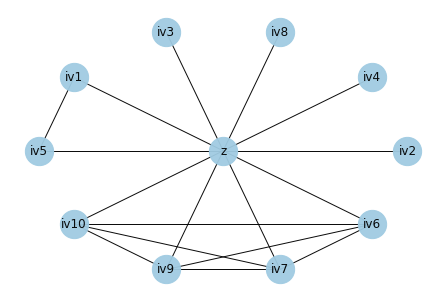

In [3]:
mdl.iv_mdl.draw_graph()

# Instrumental Variable Synthesis (Ivy)

With the data prepared, we can run Ivy! We briefly describe the algorithmic procedure of Ivy:

* **Learning Dependencies and Validity**: Ivy takes all the IV candidates as input to compute a sample covariance matrix. This matrix is decomposed in a robust PCA fashion in order to estimate the validity and dependencies of the IV candidates. 

* **Synthesize a High-quality IV**: Ivy then learn a model that estimates the value of the desired, valid, high-quality IV given the subset of valid IVs and dependencies learned from the previous step.

## Learning Dependencies and Validity

Here we learn the dependencies and validity among  the IV candidates directly from the data. The algorithm takes the IV candidate matrix (IVs) as input and output a sparse matrix (`S`) that encodes dependencies and an accuracy vector (`l`) that indicates how predictive an IV candidate is to the value of `z`. 

We can read off the sparsity pattern in `S` as the dpendencies among IV candidates and choose the subset of IV candidates that have high enough accuracy in predicting `z` as valid IVs.

In [4]:
# learn the accuracy vector l and dependency matrix S
l, S, _ = Ivy().dependency_validity(IVs/2)

# thresholding l in a data-dependent hyperparameter-free fashion to get the valid IVs
valid_indx = Ivy().get_valid_iv_indx(l)

# create the submatrix of valid IVs
IVs_valid = IVs[:,valid_indx]

# thresholding S in a data-dependent hyperparameter-free fashion to get the dependencies among IV candidates
deps = Ivy().get_dependencies(S)
deps_valid = [x for x in deps if (int(x[0]) in valid_indx) and (int(x[1]) in valid_indx)]

iteration: 1, error: 18.422109965330726
iteration: 4585, error: 3.03834567568594e-05


Let's see how well Ivy perform in recovering the depenencies and valid IVs among IV candidates:

In [5]:
print(f"F1 score of reocvering dependencies: {get_f1(deps_valid,mdl.iv_mdl.dependency):.3f}")
print(f"F1 score of recovering valid IVs: {get_f1(valid_indx,list(range(p))):.3f}")

F1 score of reocvering dependencies: 1.000
F1 score of recovering valid IVs: 1.000


## Synthesize a High-quality IV

Now that we have learned the subset of valid IVs and their dependencies. We are ready to syntehsize a high-quality IV (`z_hat`) from the candidates that are valid IVs and their dependencies!

In [6]:
# create an Ivy model
ivy = Ivy()

# train an Ivy model
use_canonical = True if len(deps_valid) else False
ivy.train(IVs_valid,deps=deps_valid,use_canonical=use_canonical)

# infer the probability of z=1 for a given configuration of valid IVs
z_hat = ivy.predict_proba(IVs_valid)

Error: 0.024265442855176476


With both the ground truth `z` and the corresponding estimation `z_hat` given by Ivy, we can evaluate how well `z_hat` is recovering `z` by the area under curve of the receiver operating characteristics (AUROC):

In [7]:
print(f"AUROC of z_hat predicting z: {roc_auc_score(z,z_hat):.5f}")

AUROC of z_hat predicting z: 0.98240


# Causal Effect Estimation

With the synthesized IV (or equivalently, the subset of valid IVs and their dependencies learned by Ivy), we are now ready to estimate causal effect! To this end, we first plug the data of the synthesized IV, along with the data from the risk factor and the outcome, into an existing causal effect estimator to estimate causal effects. We then describe the metric that we use to draw a causal conclusion.

* **Causal Effect Estimator**: We will use a classic estimator called the Wald estimator weighted by the probability of z=1 to compute causal effect (`ProbWaldEstimator`). Since we are considering a spurious relationship, we expect a good causal effect estimate to be close to zero. 
* **Metric**: We will subsample the dataset 100 times in order to derive the median and the 95% confidence interval (c.i.) of the causal estimate. We examine how close a median is to zero as a metric to measure biasedness and whether the c.i. includes zero the conclude whether the algorithm can successfully dismiss spurious relationships.

In [ ]:
%%time
method_list = [Ivy]
estimator_list = [ProbWaldEstimator]
n_trial = 100
random_seed = range(n_trial)

# estimate causal effect
wald_ratio = ComputeCausality(x, y, IVs_valid, method_list, estimator_list, 
    n_trial=n_trial, random_seed=random_seed, deps=[(int(x[0]),int(x[1])) for x in deps_valid],
    num_cores=8, use_canonical=use_canonical)

# metirc
wald_ratio_summary_df = pd.DataFrame(np.transpose(summary(wald_ratio)),columns=["ci_lower","ci_upper","median"])
print(round(wald_ratio_summary_df,3))

 88%|████████▊ | 88/100 [02:07<00:18,  1.51s/it]

# Appendix: A Primer on Causal Inference, IVs, and Ivy

* **Causal Inference**: A goal in causal inference is to estimate the causal effect between the risk factor $x$ and the outcome $y$. This effect is challenging to estimate from observational data because it is usually biased by a confounder $c$, the common cause of the risk factor and the outcome. 

* **Instrumental Variables (IVs)**: An IV $z$ is defined as a variable that influences the risk factor independently of the confounder and influences the outcome only through the risk factor (i.e. $z$ satisfies: $z\not\perp x$, $z \perp c$, and $z \perp y \mid c, x$). A variable that does not meet the IV definition is known as an invalid IV. When available in observational data, an IV can be used to estimate causal effects even where there are unmeasured confounders. Below is an illustration of how $z$,  $x$, $y$, and $c$ (unmeasured) are related to each other:

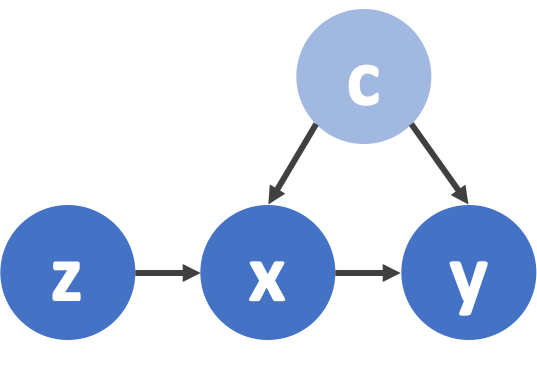

* **IV Candidates**: In many real-world scenarios, valid high-quality IVs are usually not available. Instead, practitioners make use of more widely available IV candidates that could potentially serve as IVs. Unfortunately, IV candidates can be statistically dependent on each other, or even be invalid IVs. Naively treating candidates as valid IVs without addressing dependencies and invalidity among them leads to unreliable causal estimates.

* **Instrumental Variable Synthesis (Ivy)**: To handle IV candidates, Ivy considers synthesizing a valid IV of high quality from a set of IV candidates that are potentially dependent on each other and invalid. Once such a valid high-quality IV is synthesized, it can be plugged into existing downstream IV-based causal effect estimators for causal inference.

Below is an illustration of the valid, high-quality IV $z$ and six IV candidates ($w_1$-$w_6$). $w_1$-$w_3$ are valid IVs and $w_4$-$w_6$ are invalid IVs. $w_2$ and $w_3$ are also dependent on each other. $z$ is considered unobserved by Ivy. Ivy first infers the subset of valid IVs and the dependencies among them. It then uses this information to infer the value of $z$.

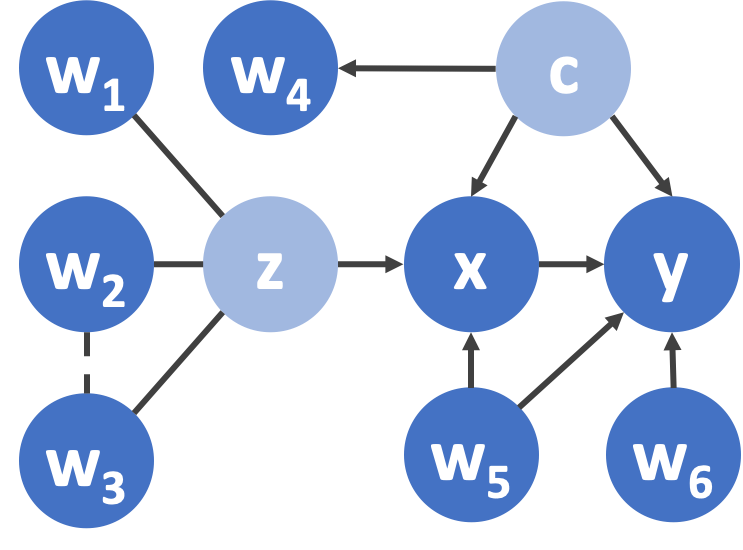